<a href="https://colab.research.google.com/github/kusawokoshitemori/MachineLearningPractice/blob/main/MachineLearningPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
pip install keras-tuner --upgrade

In [26]:
# ハーパーパラメーターの選定に使用
import keras_tuner
import keras

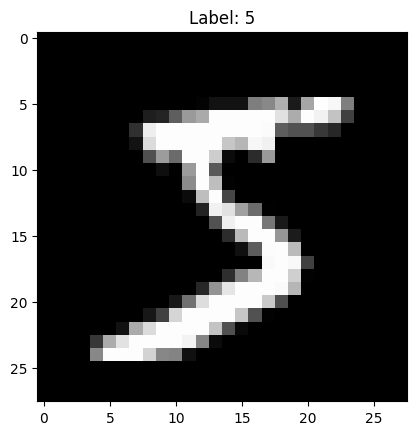

In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# MNISTデータを取得
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 訓練データを10000枚に制限
train_images = train_images[:10000]
train_labels = train_labels[:10000]

# 画像を表示
plt.imshow(train_images[0], cmap="gray")
plt.title(f"Label: {train_labels[0]}")
plt.show()


In [28]:
# 画像データを0〜1に正規化 MLP使う場合
# train_images = train_images / 255.0
# test_images = test_images / 255.0

# 画像データを0〜1に正規化 CNN使用する場合(白黒画像だから1)
train_images = train_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0


In [29]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)


In [30]:
from tensorflow.keras import models, layers, regularizers

# モデルの関数化
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='relu'))
  model.add(keras.layers.Dense(1, activation='relu'))
  model.compile(loss='mse')
  return model

In [31]:
# チューナーの初期化
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

Reloading Tuner from ./untitled_project/tuner0.json


In [37]:
print("train_images.shape:", train_images.shape)
print("test_images.shape:", test_images.shape)
print("train_labels.shape:", train_labels.shape)
print("test_labels.shape:", test_labels.shape)


train_images.shape: (10000, 28, 28, 1)
test_images.shape: (10000, 28, 28, 1)
train_labels.shape: (10000, 10)
test_labels.shape: (10000, 10)


In [33]:
tuner.search(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))
best_model = tuner.get_best_models()[0]

In [34]:
tuner.results_summary()


Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
units: 8
Score: 8.408232688903809
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _buil

In [35]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Kerasモデルのラップ
model = KerasClassifier(build_fn=build_model, verbose=0)

# ハイパーパラメータのグリッド定義
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'kernel_regularizer': [regularizers.l2(0.01), regularizers.l2(0.1)]
}

# GridSearchCVの実行
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)
grid_result = grid.fit(train_images, train_labels)

# 最適なパラメータを表示
print("Best parameters found: ", grid_result.best_params_)


ImportError: cannot import name '_center' from 'numpy._core.umath' (/usr/local/lib/python3.11/dist-packages/numpy/_core/umath.py)

In [ ]:
import sklearn
print(sklearn.__version__)  # これでバージョンを確認


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# アーリーストッピングの設定
early_stopping = EarlyStopping(
    monitor='val_loss',   # 監視対象（'val_loss' or 'val_accuracy'）
    patience=5,           # 5エポック改善しなかったらストップ
    restore_best_weights=True  # 最も良い重みを復元
)

# モデルのコンパイル
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# モデルの学習
hist = model.fit(train_images, train_labels,
                 epochs=5,
                 validation_data=(test_images, test_labels),
                 callbacks=[early_stopping])

# === 学習の可視化 ===
# 正解率の推移をプロット
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# 損失の推移をプロット
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# import numpy as np

# # 学習後、最初の1つのデータに対して予測
# predictions = model(train_images[:3]).numpy()

# # ソフトマックスで確率に変換
# probabilities = tf.nn.softmax(predictions)

# # 確率をNumPy配列に変換
# probabilities_np = probabilities.numpy()

# # NumPyでの表示設定を変更
# np.set_printoptions(precision=3, suppress=True)

# # 確率を表示
# print(probabilities_np)

# print(train_labels[:3])

In [ ]:
# import numpy as np

# # 学習後、最初の1つのデータに対して予測
# predictions = model(test_images[:3]).numpy()

# # ソフトマックスで確率に変換
# probabilities = tf.nn.softmax(predictions)

# # 確率をNumPy配列に変換
# probabilities_np = probabilities.numpy()

# # NumPyでの表示設定を変更
# np.set_printoptions(precision=3, suppress=True)

# # 確率を表示
# print(probabilities_np)

# print(test_labels[:3])

In [ ]:
# 訓練データ
train_loss, train_acc = model.evaluate(train_images, train_labels)
print("Train accuracy:", train_acc)



In [ ]:
# テストデータ
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy:", test_acc)
